In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from credalDecisionTree import credalDecisionTree
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
def flip(x):
    if x == 0:
        return 1
    else:
        return 0

flipArray = np.frompyfunc(flip, 1, 1)

In [3]:
def add_noise(x:np.ndarray, p:float):
    mask = np.random.choice([True, False], x.shape[0], [p, 1-p])
    x[mask] = flipArray(x[mask])
    return x

In [4]:
def add_cmar(x:np.ndarray, p:float):
    mask = np.random.choice([True, False], x.shape, [p, 1-p])
    x = x.astype(float)
    x[mask] = np.nan
    return x

In [5]:
x1 = np.random.choice([1,0], 100, [0.5, 0.5]).reshape(-1,1)
x2 = np.random.choice([1,0], 100, [0.5, 0.5]).reshape(-1,1)
x3 = np.random.choice([1,0], 100, [0.5, 0.5]).reshape(-1,1)
y = np.bitwise_and(np.bitwise_xor(x1, x2), x3).reshape(-1,1)

X = np.concatenate((x1,x2,x3), axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
all_scores = np.zeros((10, 10))

for i in range(10):
    noise_levels = np.arange(0, 1, 0.1)
    scores = np.zeros((10))
    for idx, level in enumerate(noise_levels):
        cdt = credalDecisionTree(s=1)
        y_noise = add_noise(y_train, level)
        cdt.fit(X_train, y_noise)
        pred = cdt.predict(X_test)
        score = accuracy_score(y_test, pred)
        scores[idx] = score
    all_scores[i] = scores

In [9]:
lower_bound = np.percentile(all_scores, 2.5, axis=0)
upper_bound = np.percentile(all_scores, 97.5, axis=0)
mean = np.mean(all_scores, axis=0)

Text(0.5, 1.0, 'Impact of Noisy on Accuracy')

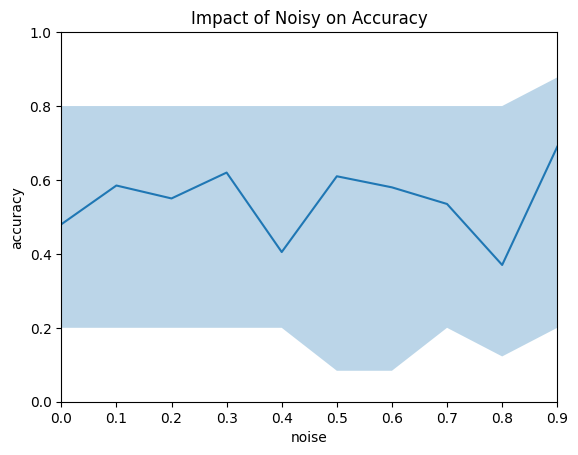

In [10]:
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=.3)
sns.lineplot(x=noise_levels, y=mean)
plt.ylim(0,1)
plt.xlim(0,0.9)
plt.xlabel('noise')
plt.ylabel('accuracy')
plt.title('Impact of Noisy on Accuracy')


In [18]:
all_scores = np.zeros((4, 10, 10))

for m_level_idx, m_level in enumerate([0.1, 0.2, 0.5, 0.8]):
    for i in range(10):  # Assuming you want 10 iterations for each m_level
        noise_levels = np.arange(0, 1, 0.1)
        scores = np.zeros((10))

        for idx, level in enumerate(noise_levels):
            cdt = credalDecisionTree(s=1)
            
            y_noise = add_noise(y_train, level)
            X_missing = add_cmar(X_train, m_level)
            X_imputed = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(X_missing)
            
            cdt.fit(X_imputed, y_noise)
            pred = cdt.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores[idx] = score

        all_scores[m_level_idx, i, :] = scores

c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entro

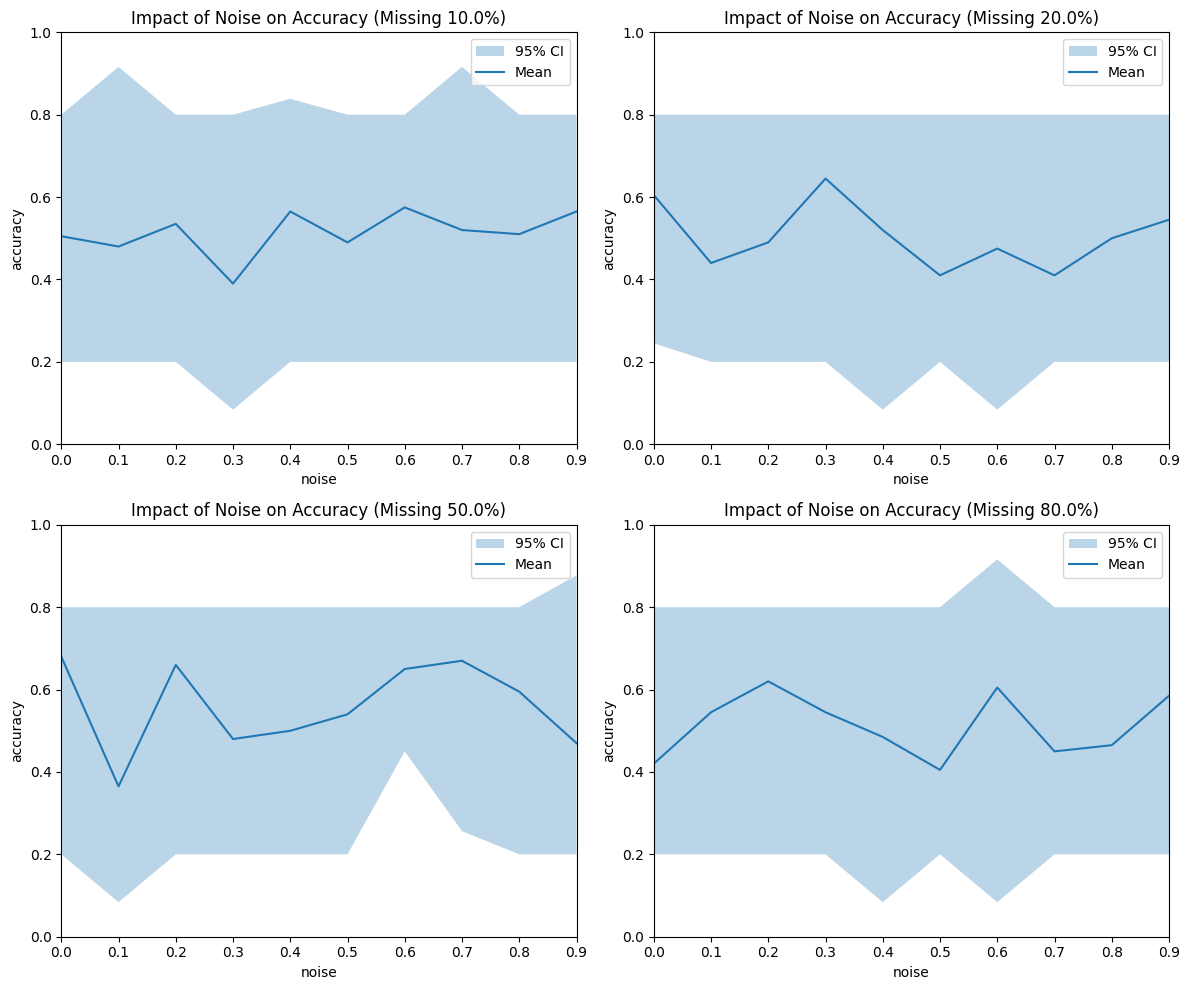

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

missing_percentages = [0.1, 0.2, 0.5, 0.8]

for m_level_idx, m_level in enumerate(missing_percentages):
    row, col = divmod(m_level_idx, 2)  # Divide by 2 to get row and column indices
    
    # Subplot for the current m_level
    ax = axes[row, col]
    
    # Extract mean and 95% CI bounds
    mean_scores = np.mean(all_scores[m_level_idx, :, :], axis=0)
    lower_bound = np.percentile(all_scores[m_level_idx, :, :], 2.5, axis=0)
    upper_bound = np.percentile(all_scores[m_level_idx, :, :], 97.5, axis=0)
    
    # Plotting
    ax.fill_between(np.arange(0, 1, 0.1), lower_bound, upper_bound, alpha=.3, label='95% CI')
    sns.lineplot(x=np.arange(0, 1, 0.1), y=mean_scores, ax=ax, label='Mean')
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 0.9)
    ax.set_xlabel('noise')
    ax.set_ylabel('accuracy')
    ax.set_title(f'Impact of Noise on Accuracy (Missing {m_level*100}%)')
    ax.legend()

plt.tight_layout()
plt.show()


In [22]:
all_scores = np.zeros((4, 10, 10))

for m_level_idx, m_level in enumerate([0.1, 0.2, 0.5, 0.8]):
    for i in range(10):  # Assuming you want 10 iterations for each m_level
        noise_levels = np.arange(0, 1, 0.1)
        scores = np.zeros((10))

        for idx, level in enumerate(noise_levels):
            cdt = credalDecisionTree(s=1)
            
            y_noise = add_noise(y_train, level)
            X_missing = add_cmar(X_train, m_level)
            X_imputed = KNNImputer().fit_transform(X_missing)
            
            cdt.fit(X_imputed, y_noise)
            pred = cdt.predict(X_test)
            score = accuracy_score(y_test, pred)
            scores[idx] = score

        all_scores[m_level_idx, i, :] = scores

c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
c:\Users\Bilal\.conda\envs\thesis\Lib\site-packages\scipy\stats\_entro

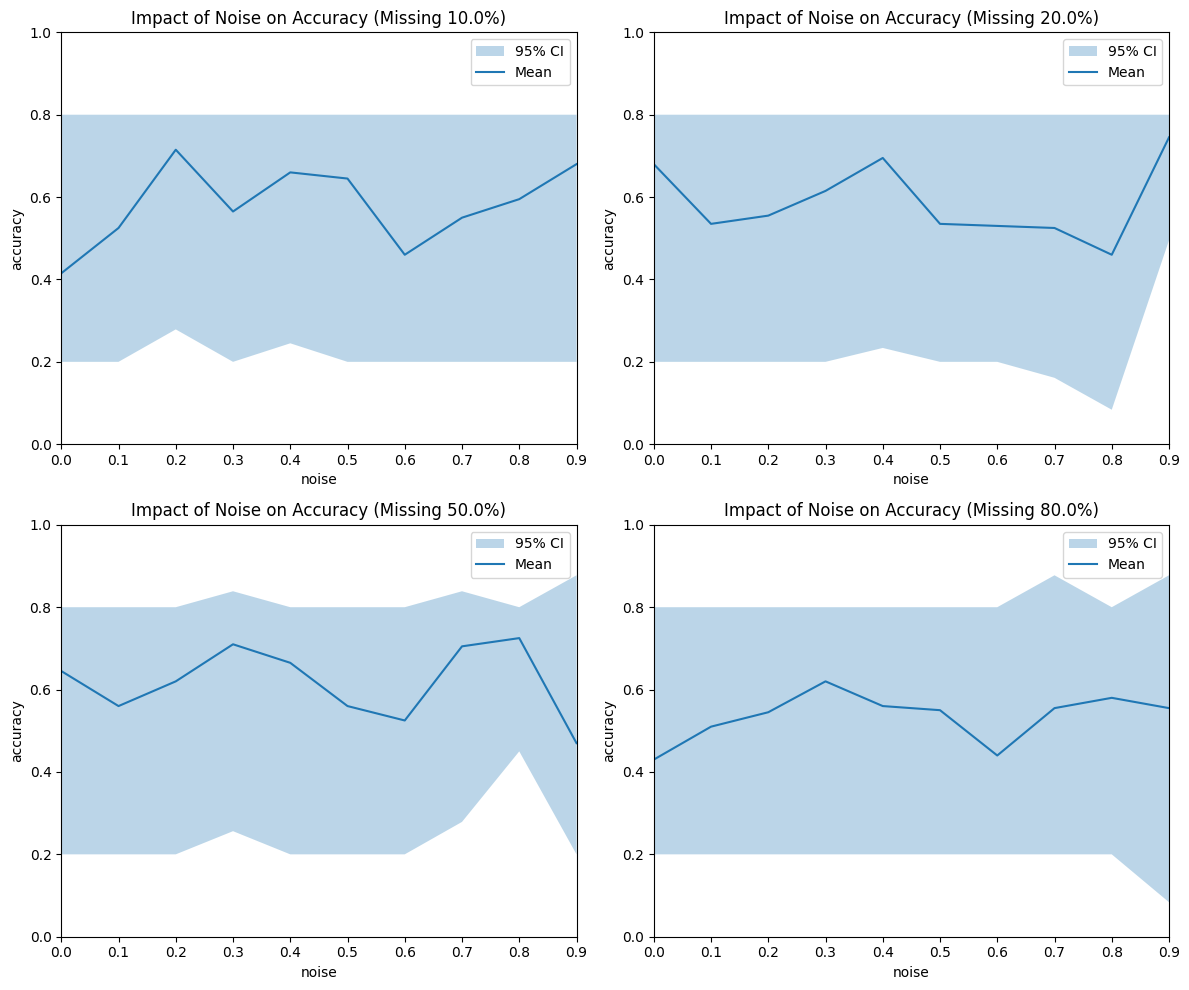

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

missing_percentages = [0.1, 0.2, 0.5, 0.8]

for m_level_idx, m_level in enumerate(missing_percentages):
    row, col = divmod(m_level_idx, 2)  # Divide by 2 to get row and column indices
    
    # Subplot for the current m_level
    ax = axes[row, col]
    
    # Extract mean and 95% CI bounds
    mean_scores = np.mean(all_scores[m_level_idx, :, :], axis=0)
    lower_bound = np.percentile(all_scores[m_level_idx, :, :], 2.5, axis=0)
    upper_bound = np.percentile(all_scores[m_level_idx, :, :], 97.5, axis=0)
    
    # Plotting
    ax.fill_between(np.arange(0, 1, 0.1), lower_bound, upper_bound, alpha=.3, label='95% CI')
    sns.lineplot(x=np.arange(0, 1, 0.1), y=mean_scores, ax=ax, label='Mean')
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 0.9)
    ax.set_xlabel('noise')
    ax.set_ylabel('accuracy')
    ax.set_title(f'Impact of Noise on Accuracy (Missing {m_level*100}%)')
    ax.legend()

plt.tight_layout()
plt.show()
